In [1]:
from cell_env import CellEnv
from stable_baselines3 import DQN

In [2]:
# Load the best model from rl-models:
# model = DQN.load("rl-models-sde/best_model.zip")
model = DQN.load(".sweep-models/woven-sweep-17/best_model.zip")
model = DQN.load(".sweep-models/toasty-sweep-35/best_model.zip")
model = DQN.load(".sweep-models/decent-sweep-88/best_model.zip")

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from gymnasium.wrappers import TimeLimit
from plot_utils import plot_observations, evaluate_model


In [4]:
# Example usage:

env_args = {
    "max_timesteps": 600,
    "alpha_mem": 0.7,
    "dt": 0.01,
    "frame_stack": 5,
}
model_str = ".sweep-models/decent-sweep-88/best_model.zip"
eval_env = CellEnv(**env_args)
avg_obs, all_obs = evaluate_model(env_args, 20, model_str, multiprocess=True)


/home/jacob.adamczyk001/Github/iaifi24-hackathon/plot_utils.py:76: RuntimeWarning: invalid value encountered in divide
  avg_observations /= counts


In [10]:
unif_obs, unif_all_obs = evaluate_model(env_args, 6, multiprocess=True)

UnboundLocalError: local variable 'model' referenced before assignment

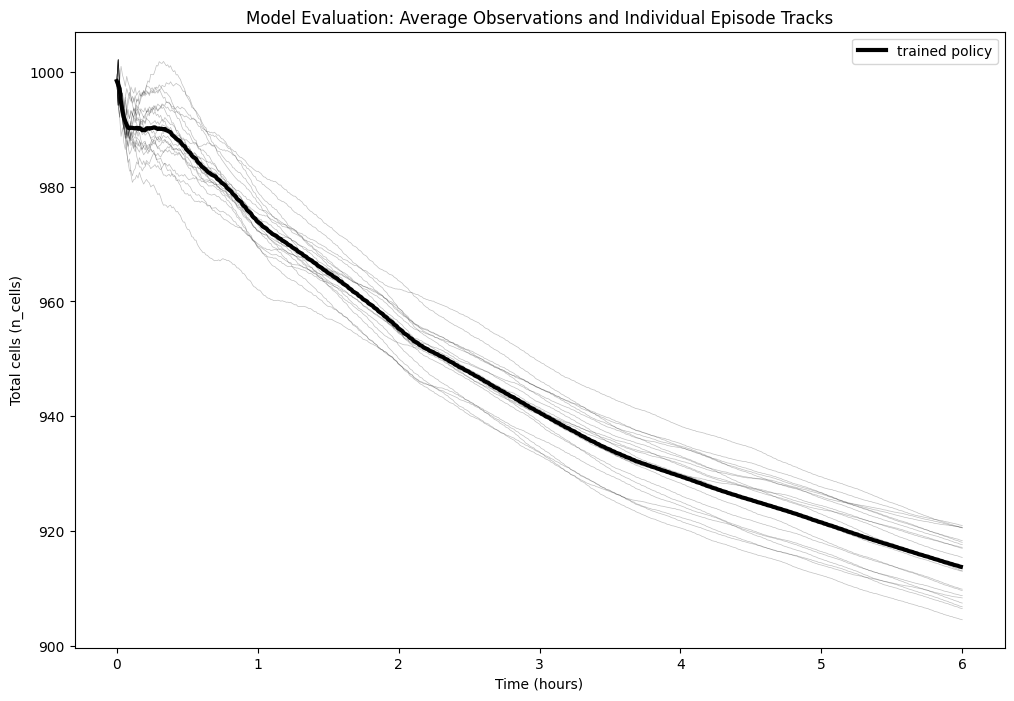

In [5]:
plot_observations(env_args, avg_obs, all_obs, alpha_val=0.25)#, unif_obs, unif_all_obs)

In [6]:

def get_actions(model, eval_env, num_episodes=1):
    """
    Evaluate the model over several episodes and plot the results.

    Parameters:
    - model: Trained RL model to be evaluated.
    - env_class: Environment class to create new instances of the evaluation environment.
    - max_steps: Maximum number of steps per episode.
    - num_episodes: Number of episodes to evaluate.

    Returns:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    all_actions = []


    for _ in range(num_episodes):
        done = False
        obs, _ = eval_env.reset()
        episode_actions = []
        while not done:
            if model is not None:
                action, _states = model.predict(obs)
            else:
                action = eval_env.action_space.sample()
            obs, rewards, term, trunc, info = eval_env.step(action)
            done = term or trunc
            episode_actions.append(action)
        
        all_actions.append(episode_actions)
    
    # Compute the average observations
    max_len = max(len(obs) for obs in all_actions)
    avg_actions = np.zeros(max_len)
    counts = np.zeros(max_len)
    
    for obs in all_actions:
        for i, val in enumerate(obs):
            avg_actions[i] += val
            counts[i] += 1
    
    avg_actions /= counts

    return avg_actions




def plot_actions(avg_actions):
    """
    Plot the average observations and individual episode tracks.

    Parameters:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    plt.figure(figsize=(12, 8))
    max_steps = len(avg_actions)
    x_axis = np.linspace(0, 0.01*max_steps, max_steps)

    # Plot average observations
    plt.plot(x_axis, avg_actions, label='trained policy', linewidth=3, color='black')
    plt.xlim(0,5)
    # do a sliding window average
    # window_size = 20
    # avg_actions_smooth = np.convolve(avg_actions, np.ones(window_size)/window_size, mode='valid')
    # x_axis = np.linspace(0, 0.15*len(avg_actions_smooth), len(avg_actions_smooth))
    # plt.plot(x_axis, avg_actions_smooth, label='trained policy', linewidth=3, color='black')
    # try calculating frequency of actions with fourier transform
    plt.figure(figsize=(12, 8))
    avg_actions = np.array(avg_actions)
    avg_actions = avg_actions - np.mean(avg_actions)
    avg_actions = np.abs(np.fft.fft(avg_actions))
    avg_actions = avg_actions[:len(avg_actions)//2]
    x_axis = np.linspace(0, 0.15*len(avg_actions), len(avg_actions))
    plt.plot(avg_actions, label='trained policy', linewidth=3, color='black')

     

    # plt.xlabel('Time (hours)')
    plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Action (use of drug)')
    plt.ylabel('Counts')
    plt.title('Model Evaluation: Action usage')
    plt.legend()
    # plt.yscale('log')
    plt.show()


In [7]:
avg_actions = get_actions(model, eval_env, 1)

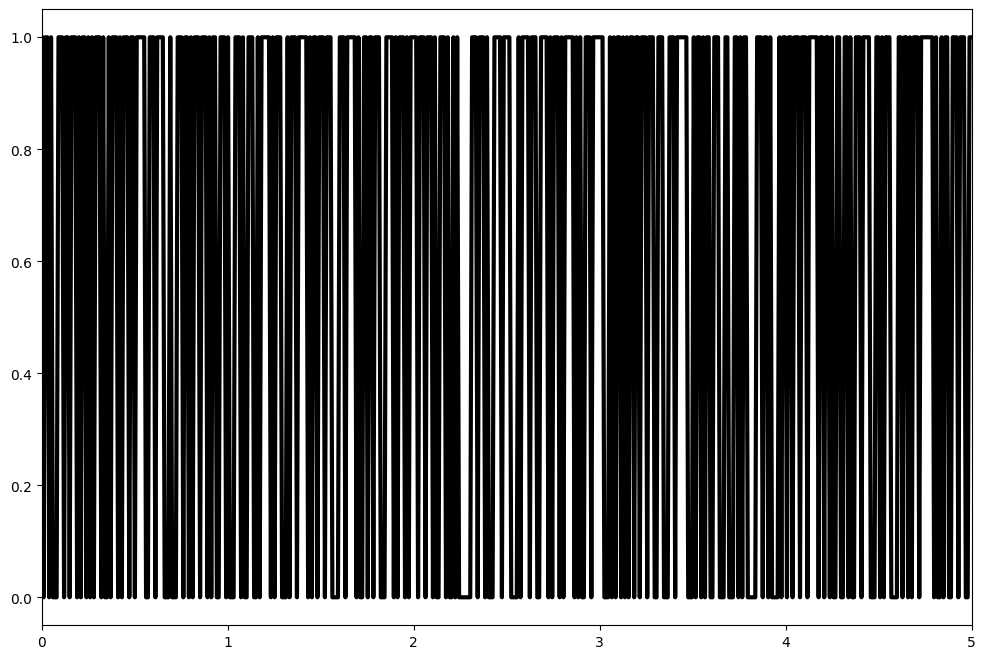

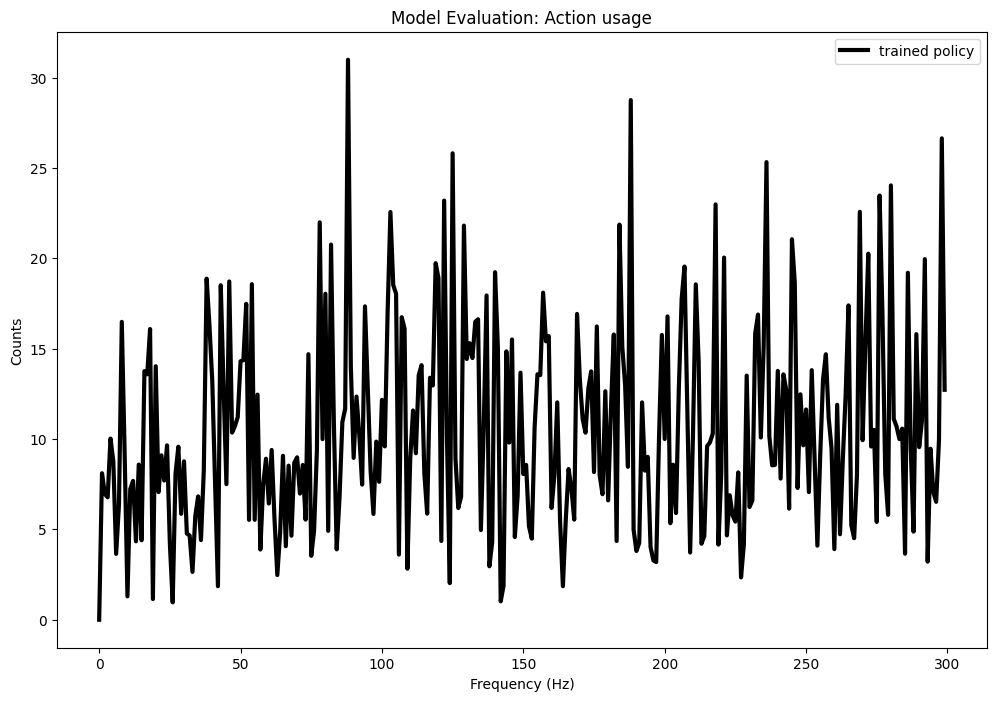

In [8]:
# view actions:
plot_actions(avg_actions)

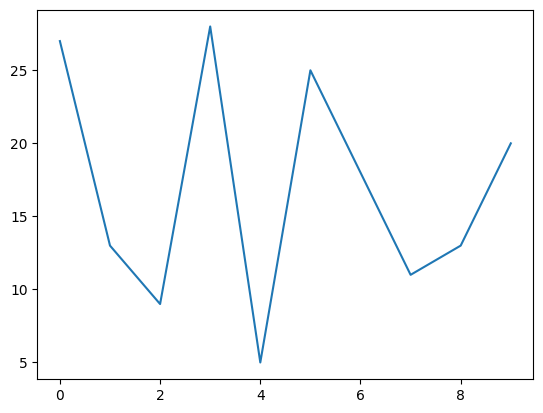

In [9]:
# bin the actions and plot average frequency in each bin over time:
avg_actions = np.array(avg_actions)
freqs=[]
time_chunks = 10
for i in range(time_chunks):
    interval = len(avg_actions)//time_chunks
    action_subset = avg_actions[interval*i:interval*(i+1)]
    # Do FT and get max frequency
    action_subset = action_subset - np.mean(action_subset)
    action_subset = np.abs(np.fft.fft(action_subset))
    action_subset = action_subset[:len(action_subset)//2]
    freqs.append(np.argmax(action_subset))
plt.plot(freqs)
